In [1]:
import numpy as np
import random
from scipy.fft import fft, fftfreq
import jax
import jax.numpy as jnp
import optax
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import StronglyEntanglingLayers
from IPython.display import clear_output
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression

# Generate data

In [2]:
# Constants
NUM_POINTS = 200
NUM_DIMENSIONS = 2

In [3]:
def generate_non_uniform_fourier_series(num_frequencies: int, max_frequency: float):
    """Generate function f(x) that returns a sum of cosines with
    random amplitudes, frequencies and phases."""
    
    frequencies = [max_frequency * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    amplitudes = [random.random() for _ in range(num_frequencies)]
    phases = [2 * np.pi * random.random() for _ in range(num_frequencies)]
    # discontinuities = [NUM_POINTS * SAMPLE_SPACING * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    print(f"Frequencies: {frequencies}")
    print(f"Amplitudes: {amplitudes}")
    print(f"Phases: {phases}")
    # print(f"Discontinuities: {discontinuities}")
    def f(x: np.ndarray):
        res = 0
        for frequency, amplitude, phase in zip(frequencies, amplitudes, phases):
            res += amplitude * np.cos(np.dot(x, frequency) + phase)
        return res
    return f

In [4]:
def generate_regression_data(inputs: np.ndarray, noise: float = 0):
    """Function used to generate noisy data."""
    data = np.array([f(input) for input in inputs])
    # add some random noise to data
    noisy_data = data + np.random.normal(0, noise, data.shape)
    noisy_data /= np.max(abs(noisy_data))
    return data, noisy_data

In [5]:
f = generate_non_uniform_fourier_series(num_frequencies=3, max_frequency=5)

Frequencies: [array([3.12747552, 3.59921769]), array([1.01299798, 2.02485813]), array([3.87694577, 3.93186892])]
Amplitudes: [0.7725348117299194, 0.9034543133697779, 0.6886861499850858]
Phases: [1.415389147056415, 3.2534054484335013, 0.7228363448300091]


In [6]:
# Data
X = np.random.random((NUM_POINTS, NUM_DIMENSIONS)) * 2 * np.pi
labels, Y = generate_regression_data(inputs=X, noise=0.1)

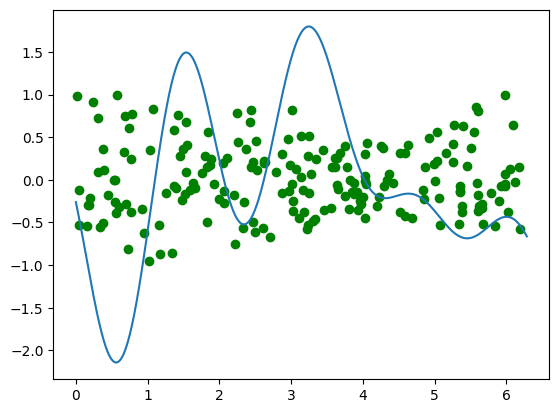

In [7]:
# Plot
all_x = np.linspace(0, 2 * np.pi, 1000)
plt.plot(all_x, [f([x] + [0] * (NUM_DIMENSIONS - 1)) for x in all_x])
plt.scatter(X[:, 0], Y, color="green")
plt.show()

# Compute cutoff frequency

In [8]:
# def centered_dft(data):
#     "computes the centered dft of a list of data values"
#     N=len(data)
#     M = np.array([[np.exp(-2j * np.pi * (i - (N - 1) / 2) * (j - (N - 1) / 2) / N) for i in range(N)] for j in range(N)])
#     dft=np.matmul(M,data)
#     return dft

In [9]:
# def inverse_centered_dft(data):
#     N=len(data)
#     def f(x):
#         M = np.array([np.exp(2j * np.pi * (x - (N - 1) / 2) * (j - (N - 1) / 2) / N) for j in range(N)])
#         dft = np.dot(M, data) / N
#         return dft
#     return f

In [10]:
# # CDFT
# y_dft = centered_dft(data=Y)
# x_dft = np.linspace(0, np.pi * (NUM_POINTS - 1) / NUM_POINTS, NUM_POINTS // 2 - 1)
# # Inverse
# y_inverse = inverse_centered_dft(data=y_dft)

In [11]:
# # Plot
# fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(8, 3))
# ax0.set_title("Centered discrete Fourier transform")
# ax0.plot(x_dft, np.abs(y_dft[NUM_POINTS // 2 + 1:]))
# ax1.set_title("Inverse") 
# ax1.plot([np.real(y_inverse(x)) for x in np.linspace(0, len(X), len(X) * 10)])
# plt.tight_layout()

In [12]:
# # Compute peaks of CDFT
# half_y_dft = np.abs(y_dft[NUM_POINTS // 2 + 1:])
# rel_height = 1/3
# max_height = np.max(half_y_dft)
# peak_indices, _ = find_peaks(half_y_dft, height=rel_height * max_height)
# if len(peak_indices) > 0:
#     max_peak_idx = np.max(peak_indices)
#     peak_width = peak_widths(x=half_y_dft, peaks=[max_peak_idx], rel_height=0.9)[0]
#     cutoff_frequency = np.max(x_dft[round(max_peak_idx + peak_width[0])])
# else:
#     cutoff_frequency = 0.1
# print(f"Cutoff frequency: {cutoff_frequency}")

# Random fourier features

In [13]:
rbf_feature = RBFSampler(gamma=1, random_state=1, n_components=1000)
X_features = rbf_feature.fit_transform(X)
weights = rbf_feature.random_weights_

In [14]:
clf = LinearRegression()
clf.fit(X_features, Y)
clf.score(X_features, Y)

0.9999999999999999

In [15]:
betas = clf.coef_
ind = np.argpartition(betas, -50)[-50:]
higher_weights = weights[:, ind]
# The cutoff freq should be a bit more than the freq with maximum weight
cutoff_frequencies = np.max(higher_weights, axis=1)

In [16]:
print(f"Cutoff frequencies: {cutoff_frequencies}")

Cutoff frequencies: [3.38017684 3.35130457]


# Quantum model

In [17]:
NUM_LAYERS = 7

In [18]:
# Circuit
dev = qml.device("default.qubit", wires=NUM_DIMENSIONS)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights, scaling, input_data):
    for layer in range(NUM_LAYERS):
        StronglyEntanglingLayers(weights=weights, wires=list(range(NUM_DIMENSIONS)))
        for dim in range(NUM_DIMENSIONS):
            qml.RX(input_data[dim] * scaling[layer, dim],wires=dim)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,None,0))

In [19]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

In [20]:
def cost(params, input_data, labels):
    """Cost function."""
    predictions = variational_classifier(params['w'], params['s'], input_data)
    return square_loss(labels, predictions)

In [21]:
def variational_classifier(weights, scaling, input_data):
    """Add classical bias."""
    return vcircuit(weights, scaling, input_data)

# Train model

In [22]:
# Training parameters
LR = 7e-2
if NUM_DIMENSIONS > 1:
    gammas = [cutoff_frequencies[i] / NUM_LAYERS * 2 for i in range(NUM_DIMENSIONS)]
else:
    gammas = cutoff_frequencies[0] / NUM_LAYERS * 2
print(f"Gammas: {gammas}")
params = {'w': pnp.random.random((NUM_LAYERS, NUM_DIMENSIONS, 3),requires_grad=True),
          's':pnp.ones((NUM_LAYERS, NUM_DIMENSIONS),requires_grad=True) * gammas}

Gammas: [0.9657648102809556, 0.9575155921544417]


In [23]:
# Optimizer
optimizer = optax.adam(LR)
opt_state = optimizer.init(params)

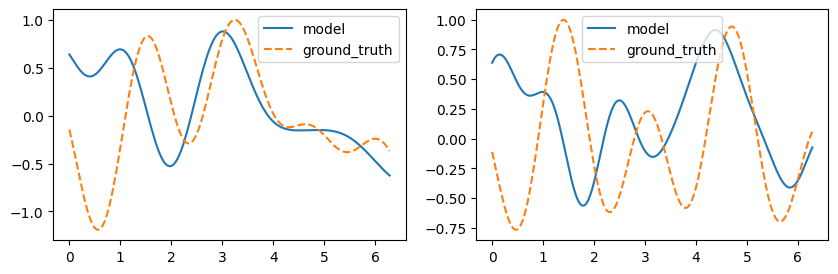

Iter:   991 | Cost: 0.0753145
[[1.0561959  1.1164469 ]
 [0.5386401  0.90216684]
 [1.0302006  0.8530709 ]
 [0.13864468 1.0773673 ]
 [0.92054445 0.9747765 ]
 [0.6575668  0.9067916 ]
 [1.3025576  1.1698648 ]]


In [25]:
# Train
ax0_x_points = np.zeros((NUM_POINTS, NUM_DIMENSIONS))
ax0_x_points[:, 0] = np.linspace(0, 2 * np.pi, NUM_POINTS)
ax0_y_points = np.array([f(point) for point in ax0_x_points])
ax0_y_points /= np.max(ax0_y_points)
ax1_x_points = np.zeros((NUM_POINTS, NUM_DIMENSIONS))
ax1_x_points[:, 1] = np.linspace(0, 2 * np.pi, NUM_POINTS)
ax1_y_points = np.array([f(point) for point in ax1_x_points])
ax1_y_points /= np.max(ax1_y_points)
for it in range(1000):
    cst, grads = jax.value_and_grad(cost)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    # s_temp = params['s']
    params = optax.apply_updates(params, updates)
    # params['s']=s_temp
    
    ax0_model_plot = variational_classifier(params['w'], params['s'], ax0_x_points)
    ax1_model_plot = variational_classifier(params['w'], params['s'], ax1_x_points)
    if it%10==0:
        clear_output(wait=True)
        fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(10, 3))
        ax0.plot(ax0_x_points[:, 0], ax0_model_plot, label='model')
        ax0.plot(ax0_x_points[:, 0], ax0_y_points,linestyle='dashed',label='ground_truth')
        ax0.legend()
        ax1.plot(ax1_x_points[:, 1], ax1_model_plot, label='model')
        ax1.plot(ax1_x_points[:, 1], ax1_y_points,linestyle='dashed',label='ground_truth')
        ax1.legend()
        plt.show()
        print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")
        print(params['s'])